# Telecom Churn Prediction - Starter Notebook

**Author:** Akshay Sehgal (www.akshaysehgal.com)

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [2]:
#pip install missingno

  Obtaining dependency information for missingno from https://files.pythonhosted.org/packages/87/22/cd5cf999af21c2f97486622c551ac3d07361ced8125121e907f588ff5f24/missingno-0.5.2-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [43]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_columns', None) 

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [44]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [45]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

#data = pd.read_csv("/kaggle/input/kagglelabstest2021/train.csv")
#unseen = pd.read_csv("/kaggle/input/kagglelabstest2021/test.csv")
#sample = pd.read_csv("/kaggle/input/kagglelabstest2021/sample.csv")
#data_dict = pd.read_csv("/kaggle/input/kagglelabstest2021/data_dictionary.csv")

traindata = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(traindata.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [46]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [47]:
# Cheking percentage of missing values in columns
traindata_missingvalue_perc = (round(((traindata.isnull().sum()/len(traindata.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
traindata_missingvalue_perc

,null
arpu_3g_6,74.9
count_rech_2g_6,74.9
night_pck_user_6,74.9
arpu_2g_6,74.9
date_of_last_rech_data_6,74.9
...,...
last_day_rch_amt_8,0.0
vol_2g_mb_6,0.0
vol_2g_mb_7,0.0
vol_2g_mb_8,0.0


In [96]:
# List the columns having more than 30% missing values
col_list_30perc_missing = list(traindata_missingvalue_perc.index[traindata_missingvalue_perc['null'] > 30])
col_list_30perc_missing

['arpu_3g_6',
 'count_rech_2g_6',
 'night_pck_user_6',
 'arpu_2g_6',
 'date_of_last_rech_data_6',
 'total_rech_data_6',
 'av_rech_amt_data_6',
 'max_rech_data_6',
 'count_rech_3g_6',
 'fb_user_6',
 'night_pck_user_7',
 'date_of_last_rech_data_7',
 'total_rech_data_7',
 'max_rech_data_7',
 'fb_user_7',
 'count_rech_2g_7',
 'count_rech_3g_7',
 'arpu_3g_7',
 'av_rech_amt_data_7',
 'arpu_2g_7',
 'count_rech_2g_8',
 'av_rech_amt_data_8',
 'night_pck_user_8',
 'max_rech_data_8',
 'total_rech_data_8',
 'arpu_2g_8',
 'arpu_3g_8',
 'date_of_last_rech_data_8',
 'fb_user_8',
 'count_rech_3g_8']

In [49]:
# Delete the columns having more than 30% missing values
traindata_curated = traindata.drop(col_list_30perc_missing, axis=1)

In [50]:
traindata_curated.shape

(69999, 142)

In [51]:
traindata_curated['churn_probability'].describe()

count    69999.000000
mean         0.101887
std          0.302502
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn_probability, dtype: float64

In [52]:
# List the date columns
date_cols = [k for k in traindata_curated.columns.to_list() if 'date' in k]
print(date_cols) 

['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']


In [53]:
# Dropping date columns
traindata_curated = traindata_curated.drop(date_cols, axis=1)

In [54]:
# Drop circle_id column as it is an unique identifier
traindata_curated = traindata_curated.drop('circle_id', axis=1)

In [55]:

traindata_curated.head()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,0.0,0.0,0.0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,0.0,0.00,2.23,0.00,0.28,5.29,16.04,2.33,0.00,0.00,0.00,0.00,0.00,0.00,7.53,16.04,2.61,46.34,124.38,1.01,18.75,80.61,0.0,0.00,0.0,0.0,0.0,0.0,0.0,65.09,204.99,1.01,0.0,0.0,0.0,8.20,0.63,0.00,0.38,0.0,0.0,81.21,221.68,3.63,2.43,3.68,7.79,0.83,21.08,16.91,0.00,0.00,0.00,3.26,24.76,24.71,0.00,7.61,0.21,7.46,19.96,14.96,0.0,0.0,0.0,0.0,0.0,0.0,7.46,27.58,15.18,11.84,53.04,40.56,0.0,0.0,0.66,0.0,0.0,0.0,1.11,0.69,0.00,3,2,2,77,65,10,65,65,10,65,65,0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1958,0.0,0.0,0.0,0
1,1,0.0,0.0,0.0,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,22.01,29.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,30.73,31.66,0.00,0.0,0.0,0.00,30.73,31.66,1.68,19.09,10.53,1.41,18.68,11.09,0.35,1.66,3.40,3.44,39.44,25.03,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.00,3,4,5,0,145,50,0,145,50,0,0,0,0.0,352.91,0.00,0.0,3.96,0.0,0,0,0,0,0,0,0,1,0,0,0,0,710,0.0,0.0,0.0,0
2,2,0.0,0.0,0.0,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.53,12.98,0.00,24.11,0.00,0.00,0.00,0.00,0.00,2.14,0.00,0.00,24.64,12.98,0.00,0.00,2.94,0.00,28.94,82.05,0.0,0.00,0.0,0.0,0.0,0.0,0.0,28.94,84.99,0.00,0.0,0.0,0.0,2.89,1.38,0.00,0.00,0.0,0.0,56.49,99.36,0.00,4.51,6.16,6.49,89.86,25.18,23.51,0.00,0.00,0.00,94.38,31.34,30.01,11.69,0.00,0.00,18.21,2.48,6.38,0.0,0.0,0.0,0.0,0.0,0.0,29.91,2.48,6.38,124.29,33.83,36.64,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.25,2,4,2,70,120,0,70,70,0,70,50,0,0.0,0.00,0.00,0.0,0.00,0.0,0,0,0,0,0,0,0,0,0,0,0,0,882,0.0,0.0,0.0,0
3,3,0.0,0.0,0.0,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,0.00,0.0,0.0,0.00,0.0,1.63,6.99,3.94,0.00,37.91,44.89,23.63,0.00,0.00,0.00,0.00,0.00,8.03,44.91,48.84,23.63,0.26,12.06,0.00,15.33,25.93,4.6,0.56,0.0,0.0,0.0,0.0,0.0,16.16,37

In [97]:
# Count the ROWS having more than 50% missing values
df_missing_rows_50 = traindata_curated[(traindata_curated.isnull().sum(axis=1)) > (len(traindata_curated.columns)//2)]
df_missing_rows_50.shape

(0, 135)

In [98]:
# Deleting the ROWS having more than 50% missing values
traindata_curated = traindata_curated.drop(df_missing_rows_50.index)
traindata_curated.shape

(69241, 135)

For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables. 

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [58]:
"""
ids = ['id','circle_id']
total_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(data.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

data = data[variables].set_index('id')
"""

"\nids = ['id','circle_id']\ntotal_amounts = [i for i in list(data.columns) if re.search('total.+amt',i)]\ntotal_outgoing_minutes = [i for i in list(data.columns) if re.search('total.+og.+mou',i)]\noffnetwork_minutes = [i for i in list(data.columns) if re.search('offnet',i)]\naverage_revenue_3g = [i for i in list(data.columns) if re.search('arpu.+3g',i)]\naverage_revenue_2g = [i for i in list(data.columns) if re.search('arpu.+2g',i)]\nvolume_3g = [i for i in list(data.columns) if re.search('vol.+3g',i)]\nvolume_2g = [i for i in list(data.columns) if re.search('vol.+2g',i)]\nage_on_network = [i for i in list(data.columns) if re.search('aon',i)]\n\n#Storing them in a single flat list\nvariables = [*ids, \n             *total_amounts, \n             *total_outgoing_minutes, \n             *offnetwork_minutes, \n             *average_revenue_3g, \n             *average_revenue_2g,\n             *volume_3g,\n             *volume_2g,\n             *age_on_network, \n             'churn_proba

In [59]:
#data.head()

Let's look at each variable's datatype:

In [60]:
traindata_curated.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69241 entries, 0 to 69998
Data columns (total 135 columns):
 #    Column              Dtype  
---   ------              -----  
 0    id                  int64  
 1    loc_og_t2o_mou      float64
 2    std_og_t2o_mou      float64
 3    loc_ic_t2o_mou      float64
 4    arpu_6              float64
 5    arpu_7              float64
 6    arpu_8              float64
 7    onnet_mou_6         float64
 8    onnet_mou_7         float64
 9    onnet_mou_8         float64
 10   offnet_mou_6        float64
 11   offnet_mou_7        float64
 12   offnet_mou_8        float64
 13   roam_ic_mou_6       float64
 14   roam_ic_mou_7       float64
 15   roam_ic_mou_8       float64
 16   roam_og_mou_6       float64
 17   roam_og_mou_7       float64
 18   roam_og_mou_8       float64
 19   loc_og_t2t_mou_6    float64
 20   loc_og_t2t_mou_7    float64
 21   loc_og_t2t_mou_8    float64
 22   loc_og_t2m_mou_6    float64
 23   loc_og_t2m_mou_7    float64
 24   loc_o

Let's also summarize the features using the df.describe method:

In [61]:
traindata_curated.describe(include="all")

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69241.000000,69241.0,69241.0,69241.0,69241.000000,69241.000000,69241.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69241.000000,69241.000000,69241.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69241.000000,69241.000000,69241.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.00000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000,69241.000000
mean,34994.619720,0.0,0.0,0.0,284.152508,279.943967,280.734946,133.153275,133.894438,132.978257,198.874771,197.153383,196.543577,9.765435,7.014568,7.004892,14.186457,9.842191,9.771783,46.904854,46.166503,45.686109,93.238231,90.799240,91.121447,3.743179,3.777031,3.661652,1.126025,1.361052,1.420840,143.893585,140.750120,140.476486,80.61

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [62]:
X = traindata_curated.iloc[:,:-1]
y = traindata_curated.iloc[:,-1]

X.shape, y.shape

((69241, 134), (69241,))

Splitting train and test data to avoid any contamination of the test data

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55392, 134), (13849, 134), (55392,), (13849,))

In [64]:
X_train.head()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
40001,40001,0.0,0.0,0.0,256.518,188.629,297.274,9.31,1.18,21.28,67.78,40.99,76.26,0.00,0.00,0.0,0.00,0.00,0.0,9.31,1.18,21.28,60.04,39.94,72.06,5.31,1.04,0.05,0.00,0.00,0.0,74.68,42.18,93.39,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,3.28,2.48,7.44,2.81,0.0,0.0,80.78,44.66,100.84,7.63,7.24,5.01,439.21,430.71,378.13,6.49,35.96,9.03,453.34,473.93,392.18,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.61,0.0,0.0,0.0,0.00,0.00,0.61,455.16,474.08,395.76,0.0,0.0,0.0,0.0,0.0,0.0,1.81,0.15,2.96,20,13,13,320,200,350,50,25,50,30,25,25,507.63,481.37,353.05,0.0,0.0,0.00,0,0,0,8,7,6,0,0,0,0,0,0,1440,0.00,0.00,0.0
54855,54855,0.0,0.0,0.0,524.480,28.493,0.000,907.19,8.16,NaN,244.24,0.00,NaN,0.00,11.58,NaN,0.00,8.93,NaN,0.31,0.00,NaN,10.61,0.00,NaN,0.00,0.00,NaN,1.48,0.00,NaN,10.93,0.00,NaN,906.88,0.00,NaN,232.14,0.00,NaN,0.0,0.00,NaN,0.0,0.0,NaN,1139.03,0.00,NaN,0.00,0.00,NaN,1.48,0.00,NaN,0.00,0.0,NaN,1151.44,0.00,0.00,23.54,0.00,NaN,7.74,0.00,NaN,0.00,0.00,NaN,31.29,0.00,NaN,43.81,0.00,NaN,20.99,0.00,NaN,0.0,0.0,NaN,0.0,0.0,NaN,64.81,0.00,NaN,96.11,0.00,0.00,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.00,NaN,15,4,2,516,30,0,44,30,0,0,0,0,0.00,0.00,0.00,0.0,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,497,0.00,0.00,0.0
12349,12349,0.0,0.0,0.0,824.750,1047.757,1702.622,324.24,935.29,1516.78,86.88,240.66,398.03,66.24,54.86,0.0,411.13,123.28,0.0,0.00,29.08,95.14,0.00,50.88,143.91,0.00,45.99,42.44,0.00,0.00,0.0,0.00,125.96,281.51,0.00,829.14,1421.63,0.00,96.61,209.46,0.0,0.95,2.2,0.0,0.0,0.0,0.00,926.71,1633.29,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,1052.68,1914.81,0.00,25.98,46.46,0.00,82.56,135.81,0.00,57.46,65.84,0.00,166.01,248.13,0.00,3.14,22.08,0.00,3.33,44.29,0.0,0.2,3.64,0.0,0.0,0.0,0.00,6.68,70.03,0.00,172.89,318.63,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.20,0.46,2,4,3,0,1350,1650,0,550,550,0,550,550,0.00,0.00,0.00,0.0,0.0,0.00,0,0,0,0,0,0,0,0,0,0,0,0,3651,0.00,0.00,0.0
7148,7148,0.0,0.0,0.0,631.665,740.195,623.418,697.28,797.24,1190.91,153.31,228.28,121.58,50.86,0.00,0.0,214.31,0.00,0.0,64.98,167.99,45.51,96.58,207.78,73.26,0.00,0.00,

# 3. Handling Missing data

First lets analyse the missing data. We can use missingno library for quick visualizations.

<Axes: >

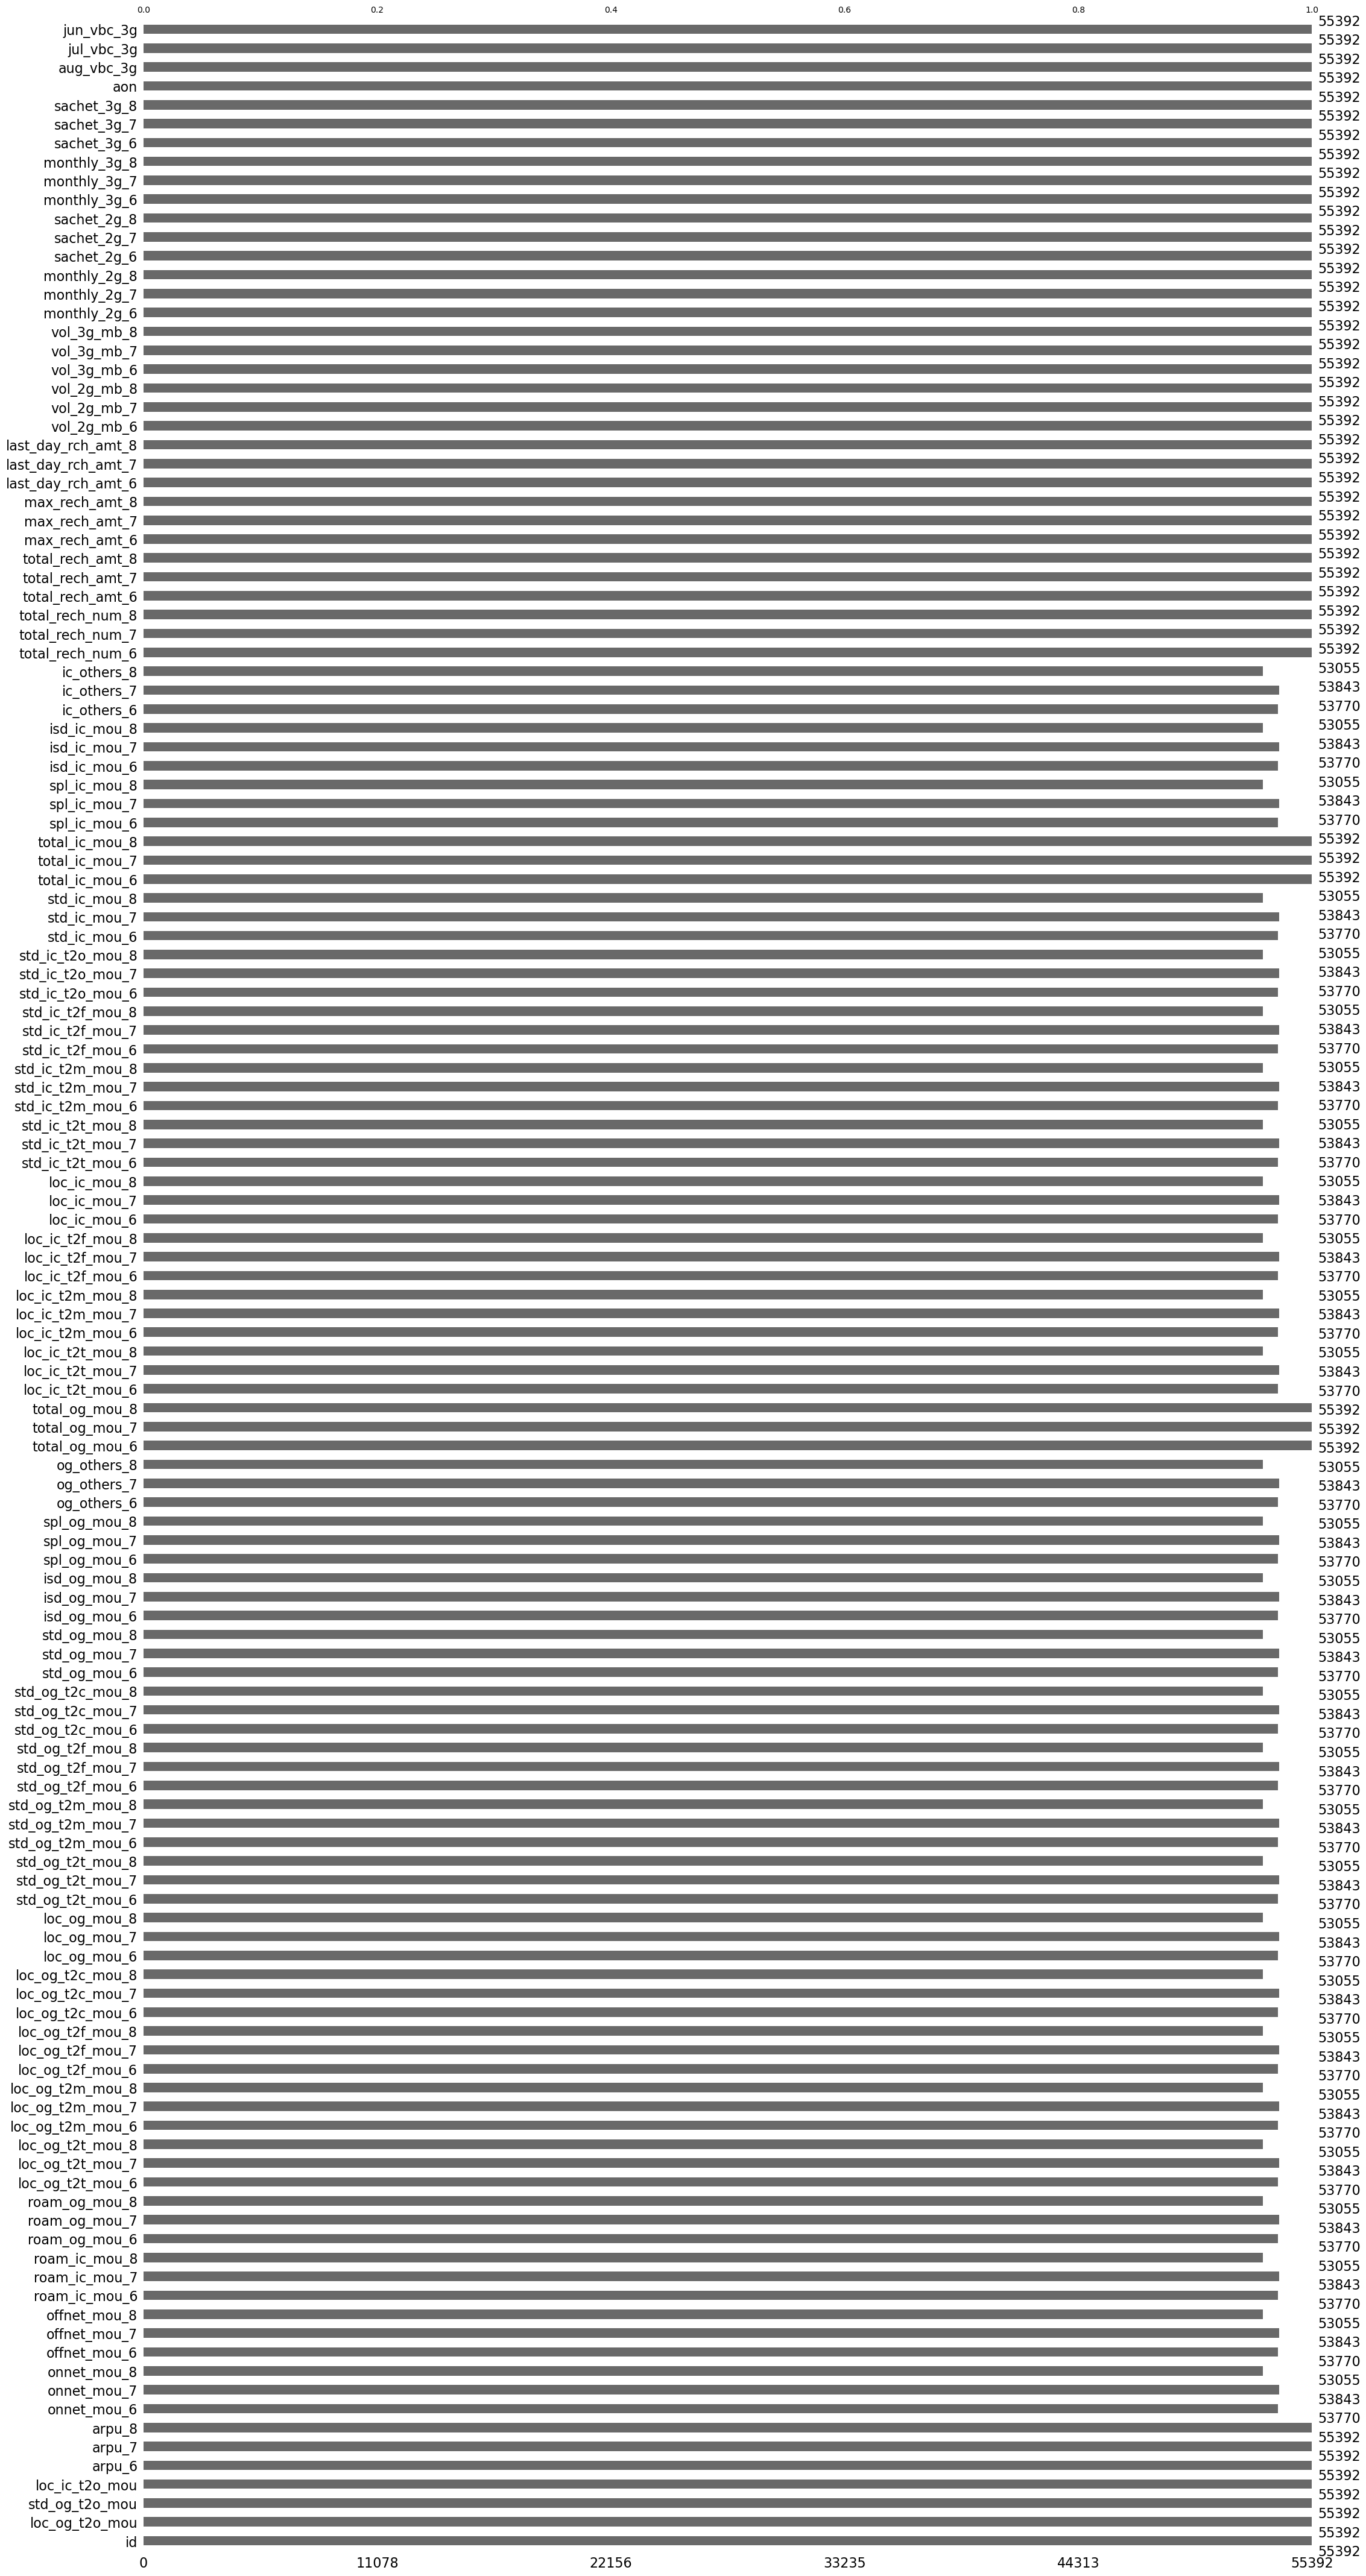

In [65]:
msno.bar(X_train)

<Axes: >

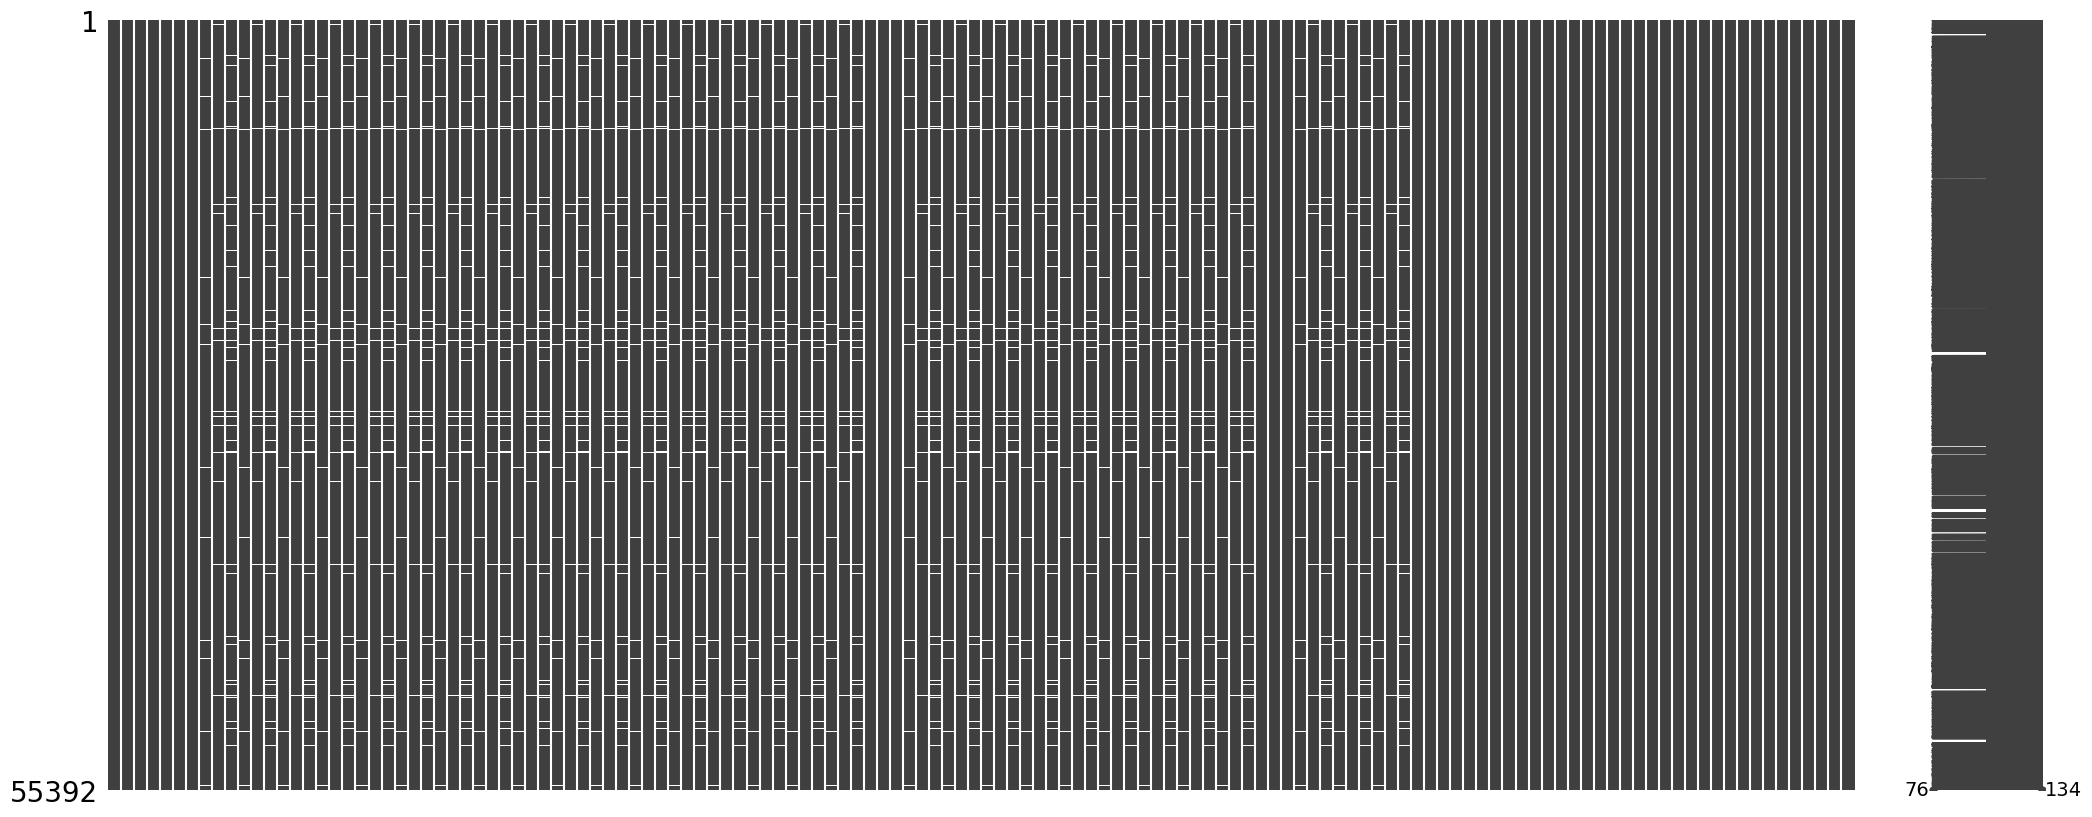

In [66]:
msno.matrix(X_train)

Lets also calculate the % missing data for each column:

In [67]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent

id                0.0
loc_og_t2o_mou    0.0
std_og_t2o_mou    0.0
loc_ic_t2o_mou    0.0
arpu_6            0.0
                 ... 
sachet_3g_8       0.0
aon               0.0
aug_vbc_3g        0.0
jul_vbc_3g        0.0
jun_vbc_3g        0.0
Length: 134, dtype: float64

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 40% missing data.

In [68]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=134)

In [69]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55392, 134)

Next, we try imputation on variables with any amount of missing data still left. There are multiple ways of imputing data, and each will require a good business understanding of what the missing data is and how you may handle it.

Some tips while working with missing data - 

1. Can simply replace missing values directly with a constant value such as 0
2. In certain cases you may want to replace it with the average value for each column respectively
3. For timeseries data, you may consider using linear or spline interplolation between a set of points, if you have data available for some of the months, and missing for the others.
4. You can consider more advance methods for imputation such as MICE.

In our case, I will just demostrate a simple imputation with constant values as zeros.

In [70]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6',
       'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7'

In [71]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

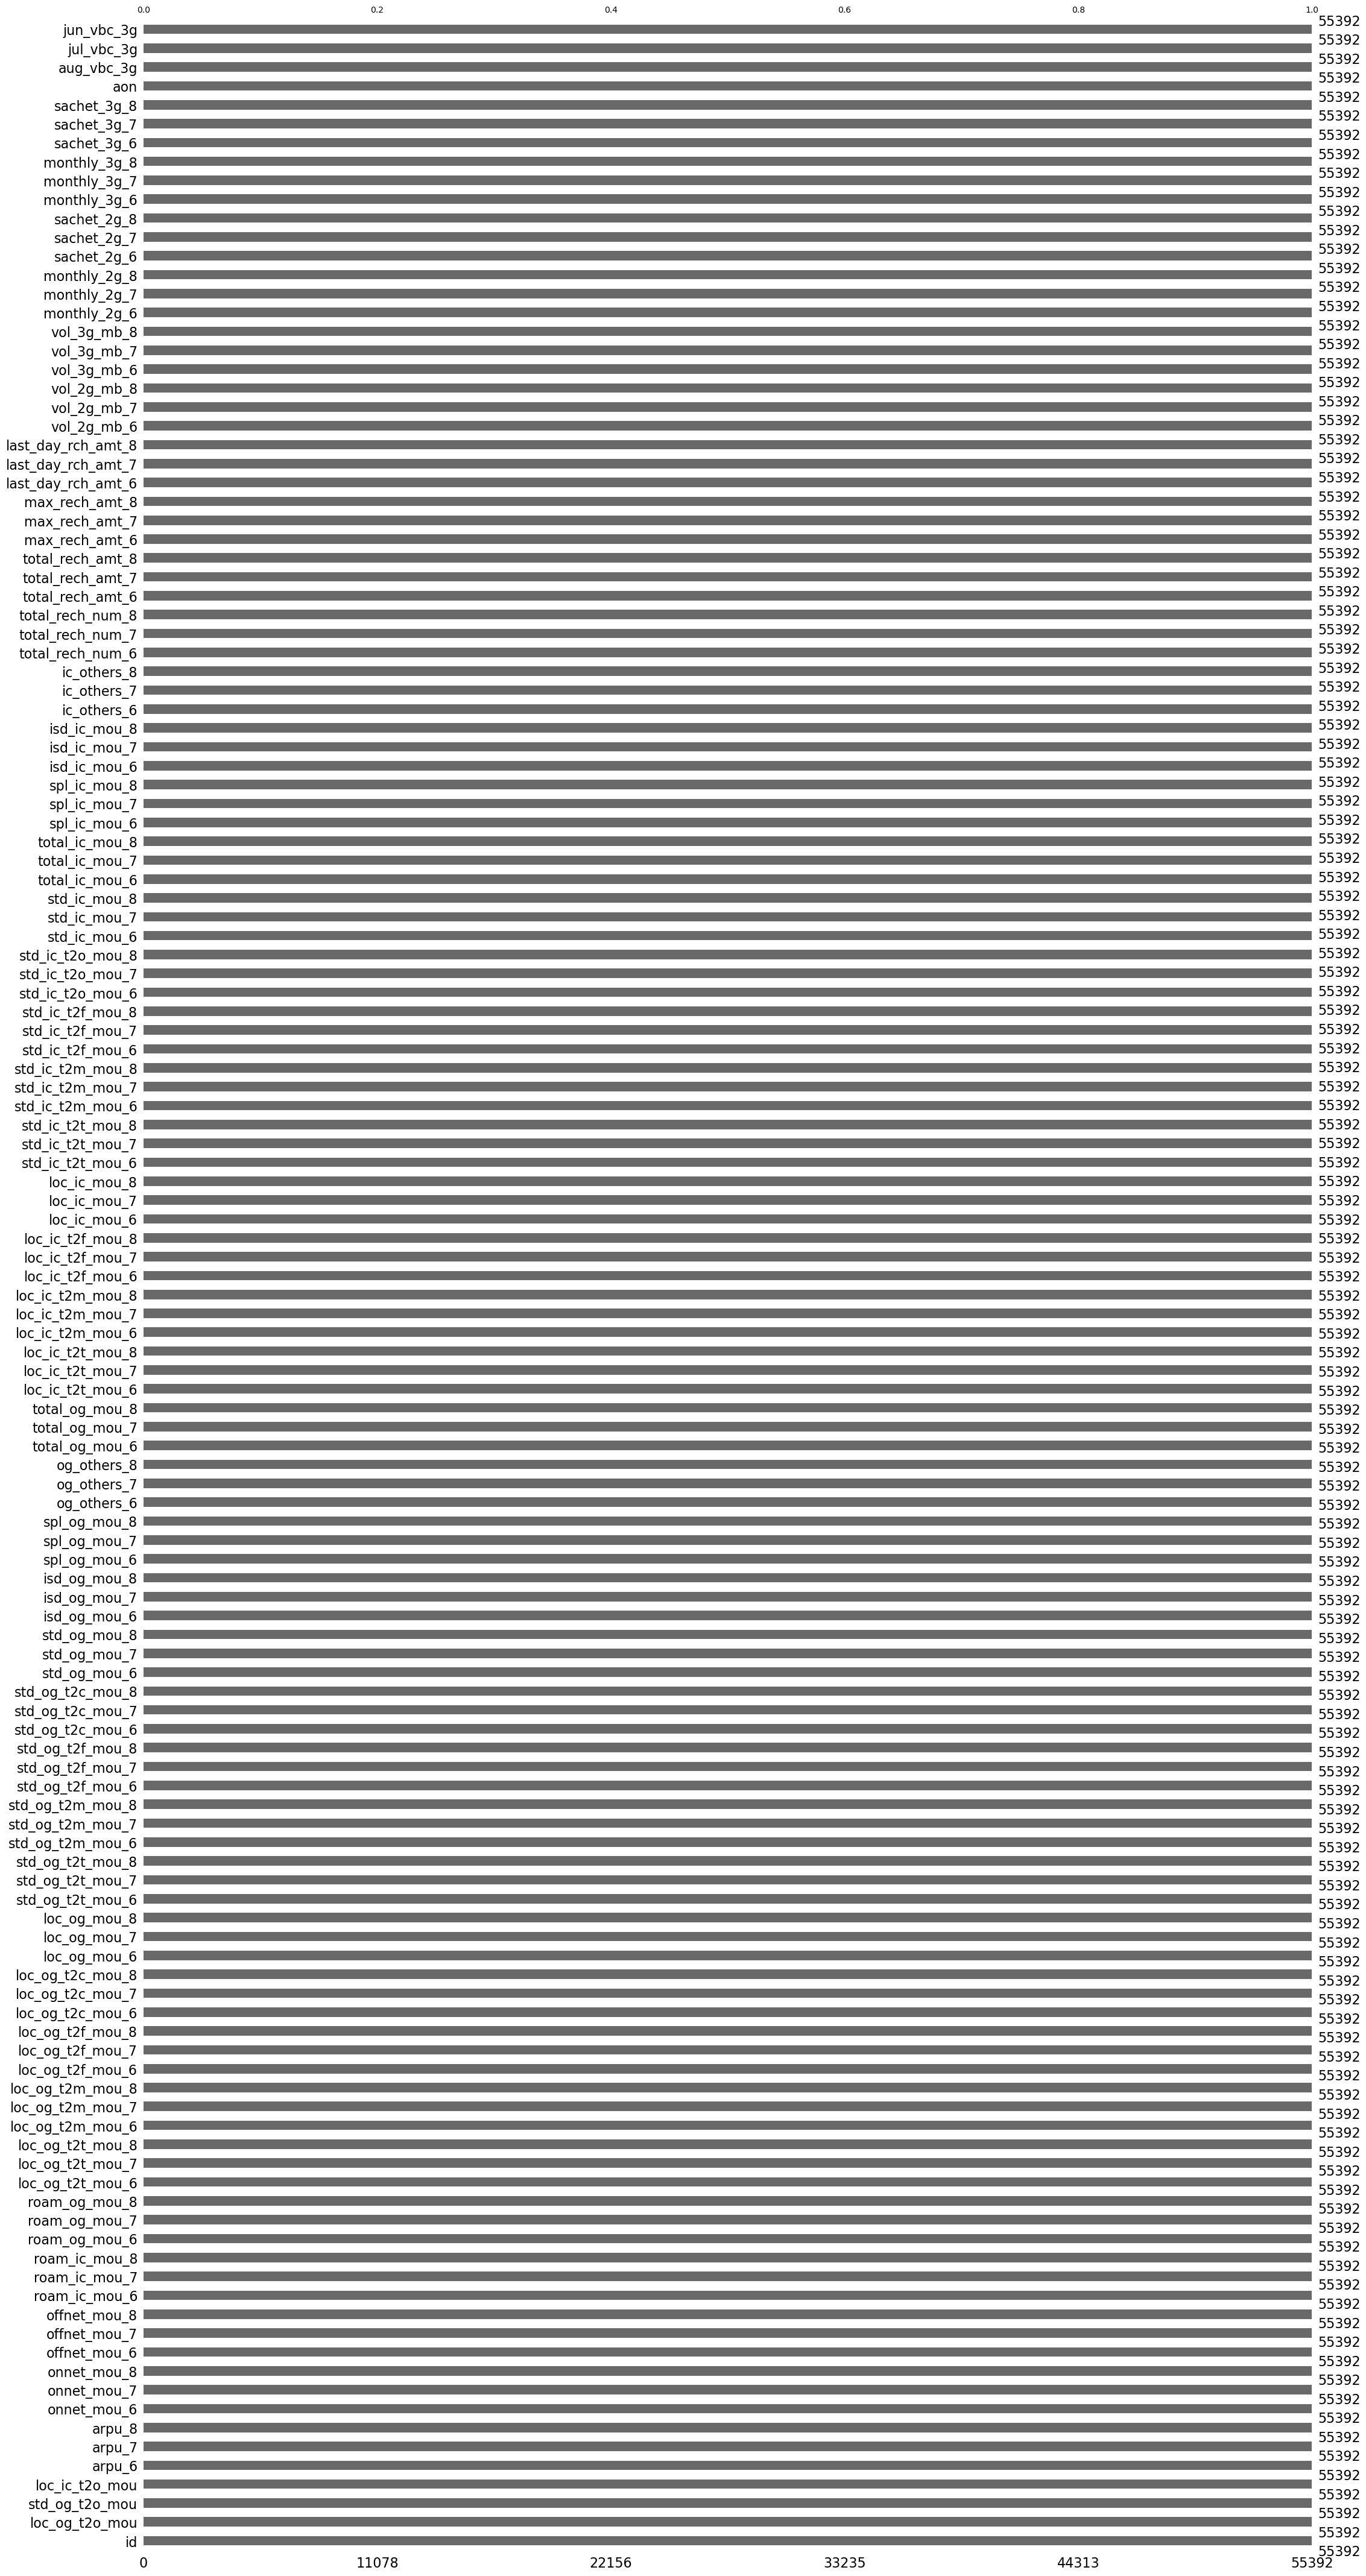

In [72]:
msno.bar(X_train_filtered)

In [73]:
X_train_filtered.describe()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,55392.000000,55392.0,55392.0,55392.0,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.0,55392.0,55392.0,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.0,55392.0,55392.0,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000,55392.000000
mean,34942.938421,0.0,0.0,0.0,283.805291,279.624251,280.507703,129.772668,130.159506,127.050413,192.642515,190.877459,187.780678,9.458079,6.974279,6.669157,13.568240,9.656292,9.271123,45.394402,44.539363,43.241926,90.308408,87.753939,86.990808,3.655858,3.696055,3.531203,1.093199,1.320490,1.372413,139.365776,135.996496,133.770922,79.050016,81.726803,80.211025,85.44

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

<Axes: >

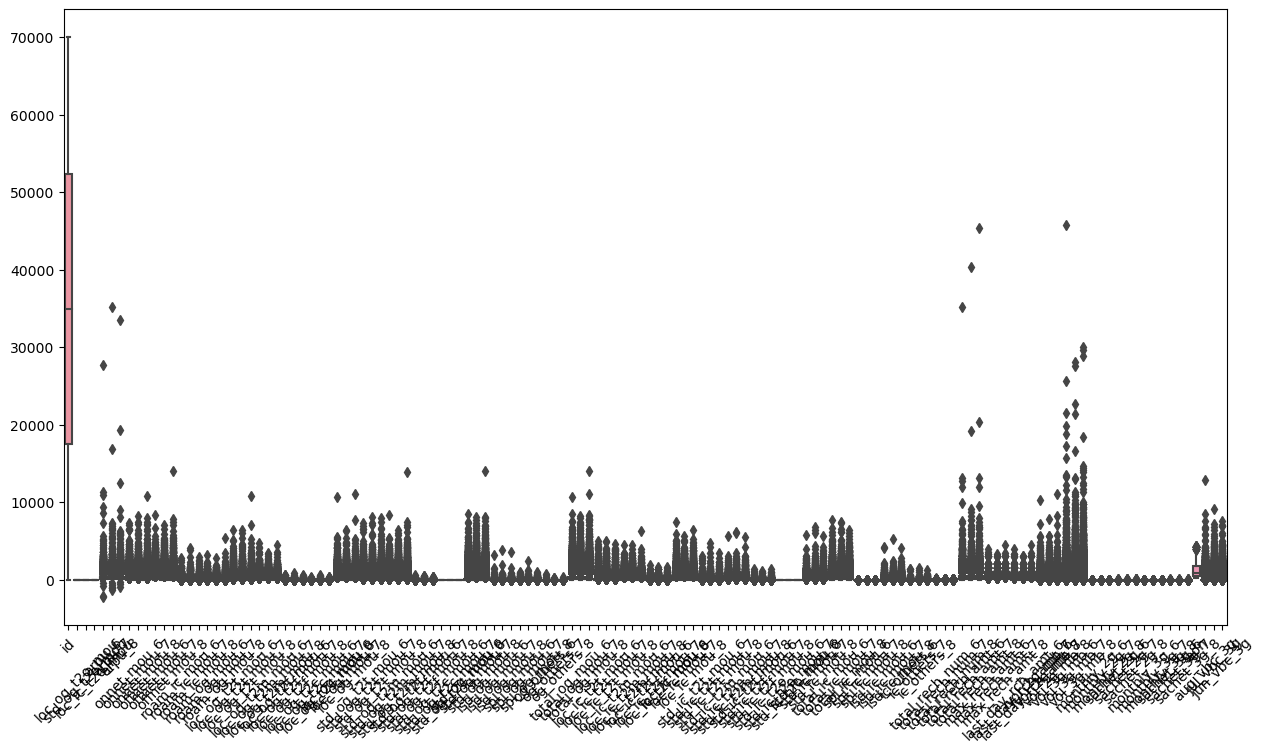

In [74]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [75]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<Axes: >

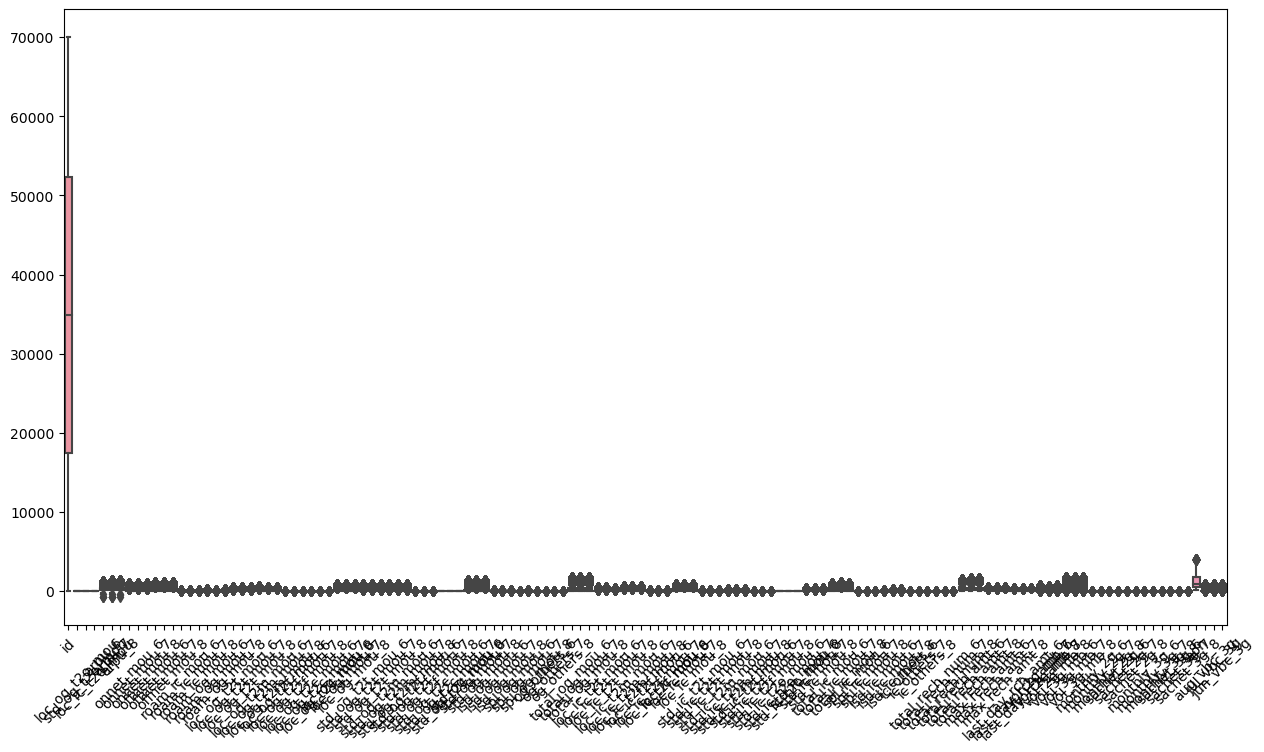

In [76]:
X_train_filtered1 = X_train_filtered.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [77]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

<Axes: >

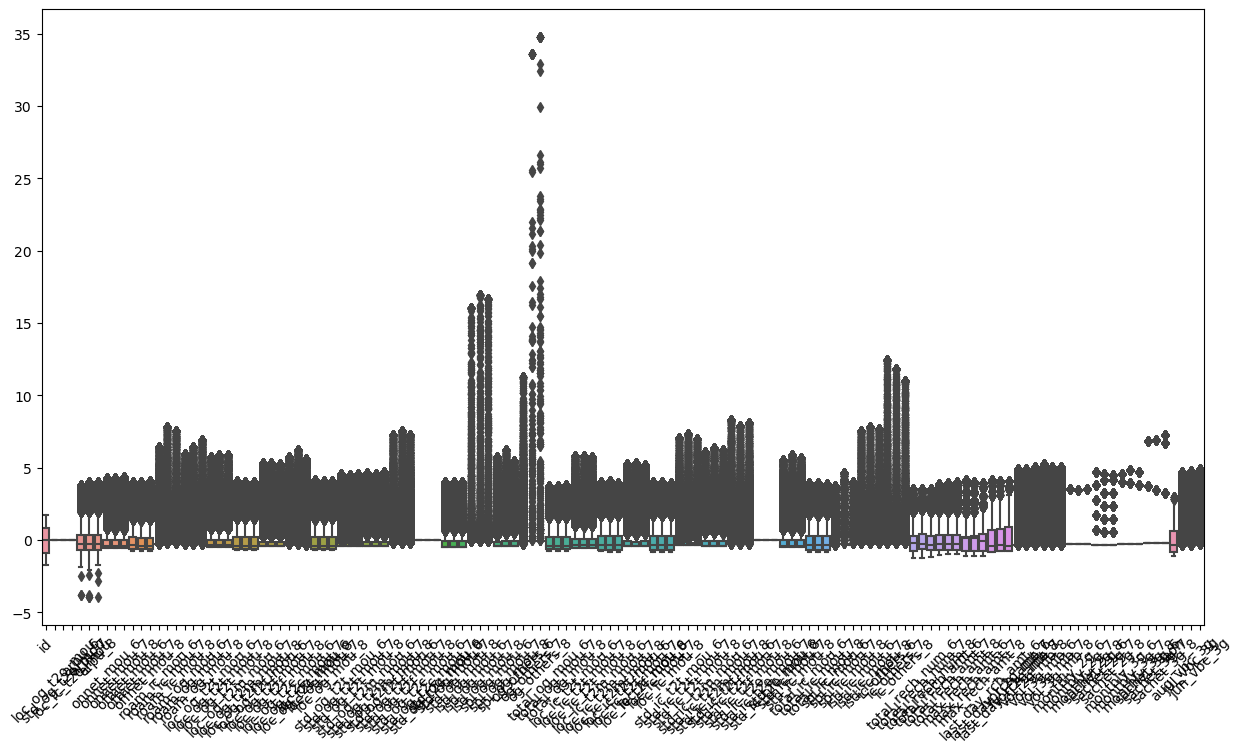

In [78]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

<Axes: >

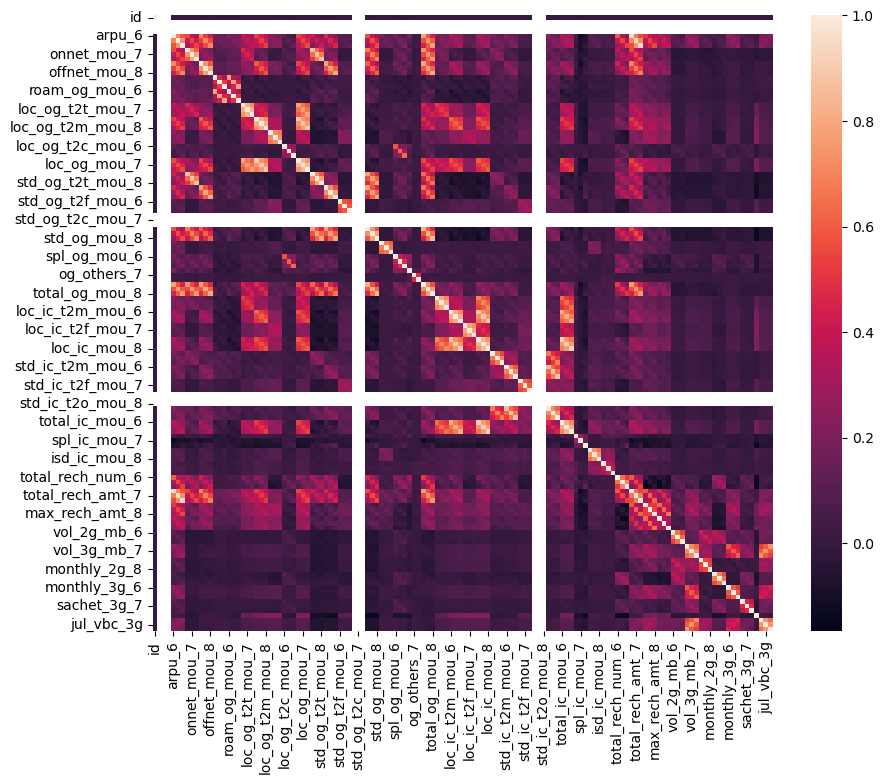

In [79]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

<Axes: xlabel='churn_probability', ylabel='Count'>

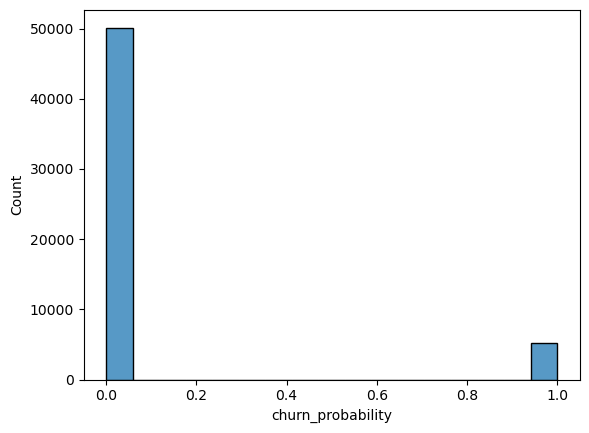

In [80]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [81]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

RandomForestClassifier(n_jobs=-1)

In [82]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

<BarContainer object of 134 artists>

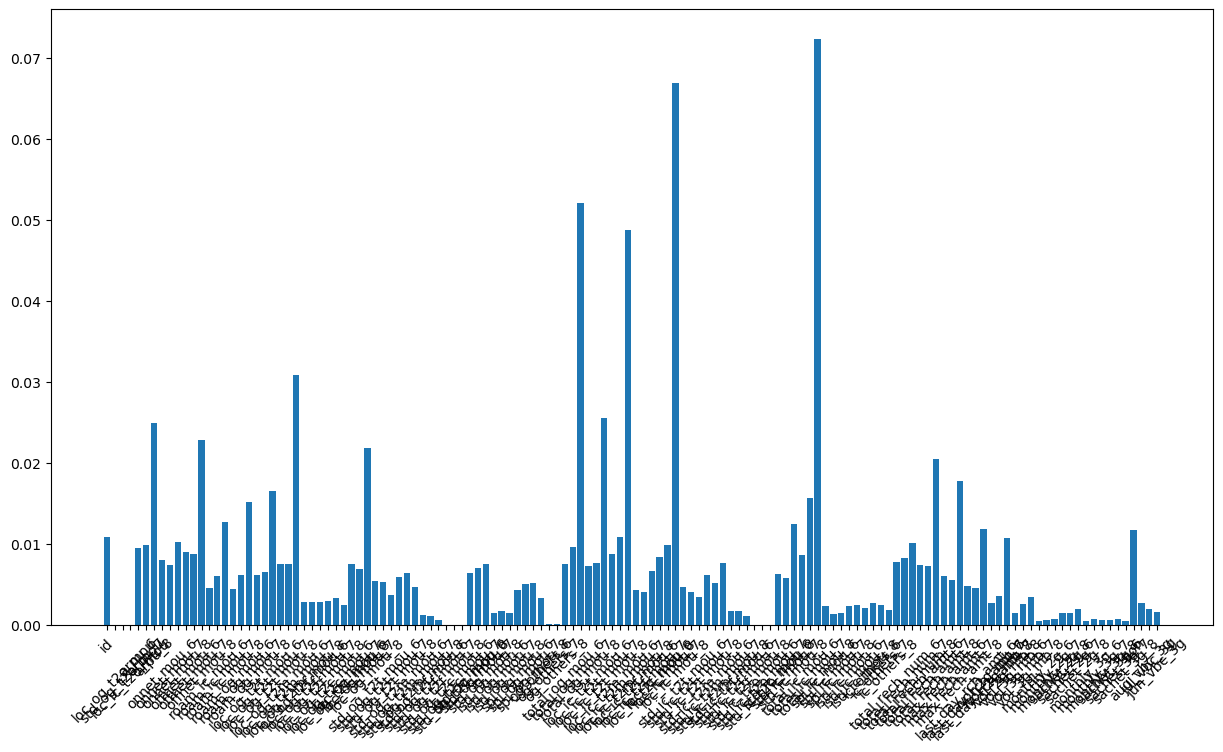

In [83]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

<Axes: >

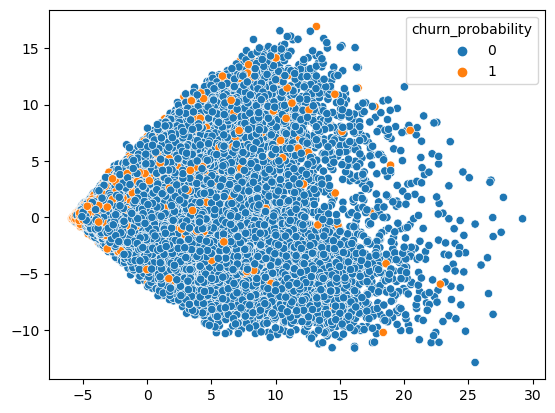

In [84]:
pca = PCA()
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

<Axes: >

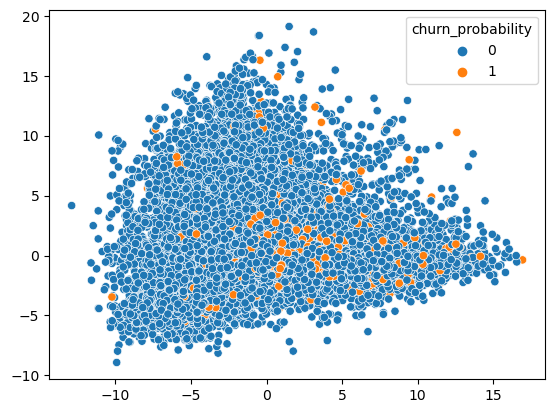

In [85]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [86]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(16)], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

ValueError: All arrays must be of the same length

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [87]:
lr = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
lr.fit(pca_components[:,:2], y_train)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [88]:
lr.score(pca_components[:,:2], y_train)

0.9052209705372617

The model has 89.8% accuracy, but let's build a pipeline to fit and score the model faster.

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model

You can change this pipeline, add addition transformations, change models, use cross validation or even use this pipeline to work with a Gridsearch.

In [89]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10)
lr = LogisticRegression(max_iter=1000, tol=0.001)

In [90]:
pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [91]:
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', LogisticRegression(max_iter=1000, tol=0.001))])

In [92]:
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.9050223859041017


In [93]:
test_score = pipe.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.9024478301682431


Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [94]:
confusion_matrix(y_train, pipe.predict(X_train[new_vars]))

array([[50023,   119],
       [ 5142,   108]], dtype=int64)

In [95]:
confusion_matrix(y_test, pipe.predict(X_test[new_vars]))

array([[12478,    28],
       [ 1323,    20]], dtype=int64)

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [ ]:
precision_score(y_test, pipe.predict(X_test[new_vars]))

In [ ]:
recall_score(y_test, pipe.predict(X_test[new_vars]))

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [ ]:
unseen.head()

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [ ]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = pipe.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv('submission_pca_lr_13jul.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.